# Targetting n&k or D for known parameters

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor

[((3.46+0.01j), 0.001), ((2.5+0.015j), 0.0005)]


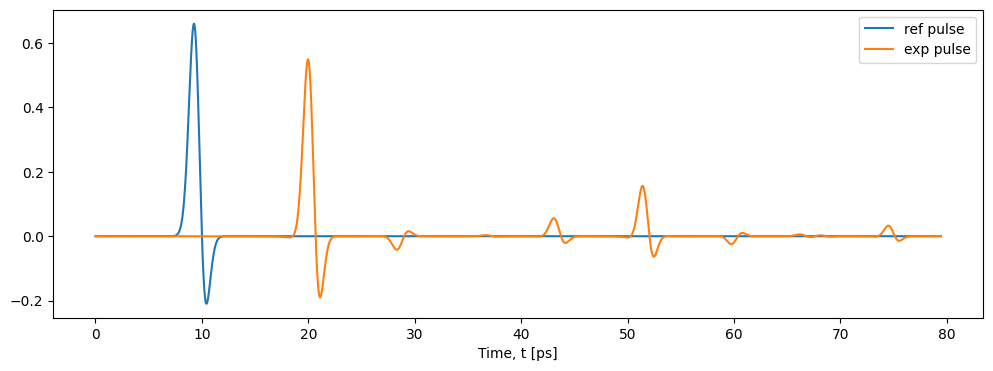

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 1e-3
n2, k2, d2= 2.5, 0.015, 0.5e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Fit just n's and k's for known d values

### Bayesian optimization to find starting parameters

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.3, 3.5)
Layer 1 - k ∈ (0.004999999999999999, 0.025)
Layer 2 - n ∈ (2.3, 2.5)
Layer 2 - k ∈ (0.007000000000000001, 0.027000000000000003)
[((3.458433916201004+0.014924226121297067j), 0.001), ((2.5+0.007000000000000001j), 0.0005)]


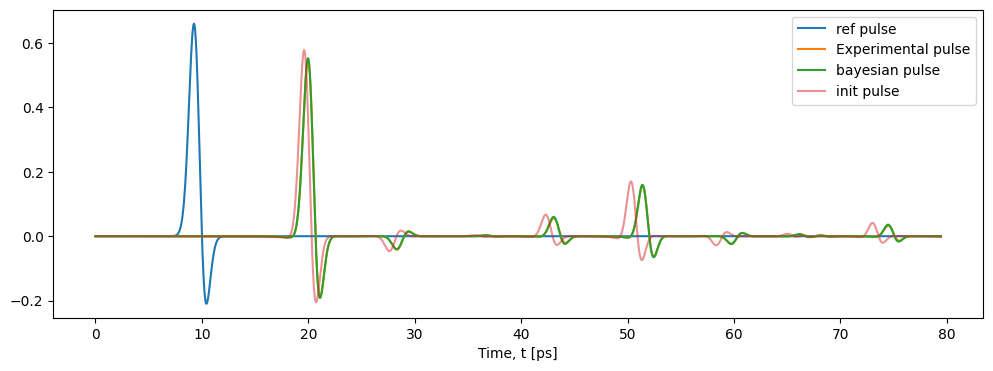

In [3]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

optimize_mask = [
    (True, True, False),  
    (True, True, False),    
]

layers_nk_init = [(3.4+0.015*1j, 1e-3), (2.4+1j*0.017, 0.5e-3)]

initial_pulse_nk = simulate_parallel(reference_pulse, layers_nk_init, deltat, 0)[1][:L]

BLE_NK = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_nk_init, optimize_mask=optimize_mask)
bayesian_NK_params = BLE_NK.bayesian_optimization(n_calls=50)
print(bayesian_NK_params)

_, bayesian_pulse_nk = simulate_parallel(reference_pulse, bayesian_NK_params, deltat, noise_level=0)
bayesian_pulse_nk = bayesian_pulse_nk[:L]

plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental pulse')
plt.plot(t_axis*1e12, bayesian_pulse_nk.detach().cpu().numpy(), label='bayesian pulse')
plt.plot(t_axis*1e12, initial_pulse_nk.detach().cpu().numpy(), label='init pulse', alpha=0.5)

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Fine-tune with Adam Gradient Decent

Optimizing n and k with initial conditions [((3.4+0.015j), 0.001), ((2.4+0.017j), 0.0005)]
Fine-tuning 4 parameters for 50 iterations.
Iteration 4, Loss: 5.562624e-04, Layer 0: n=3.4594, k=0.01400, D=1000.00 µm | Layer 1: n=2.5008, k=0.00748, D=500.00 µm
Iteration 9, Loss: 3.964322e-04, Layer 0: n=3.4598, k=0.01295, D=1000.00 µm | Layer 1: n=2.5011, k=0.00900, D=500.00 µm
Iteration 14, Loss: 3.054554e-04, Layer 0: n=3.4594, k=0.01184, D=1000.00 µm | Layer 1: n=2.5004, k=0.01085, D=500.00 µm
Iteration 19, Loss: 2.166090e-04, Layer 0: n=3.4598, k=0.01088, D=1000.00 µm | Layer 1: n=2.5006, k=0.01294, D=500.00 µm
Iteration 24, Loss: 1.252183e-04, Layer 0: n=3.4600, k=0.01011, D=1000.00 µm | Layer 1: n=2.5004, k=0.01488, D=500.00 µm
Iteration 29, Loss: 1.544766e-04, Layer 0: n=3.4601, k=0.00946, D=1000.00 µm | Layer 1: n=2.5002, k=0.01576, D=500.00 µm
Iteration 34, Loss: 8.682347e-05, Layer 0: n=3.4601, k=0.00960, D=1000.00 µm | Layer 1: n=2.5000, k=0.01608, D=500.00 µm
Iteration 39, Loss: 

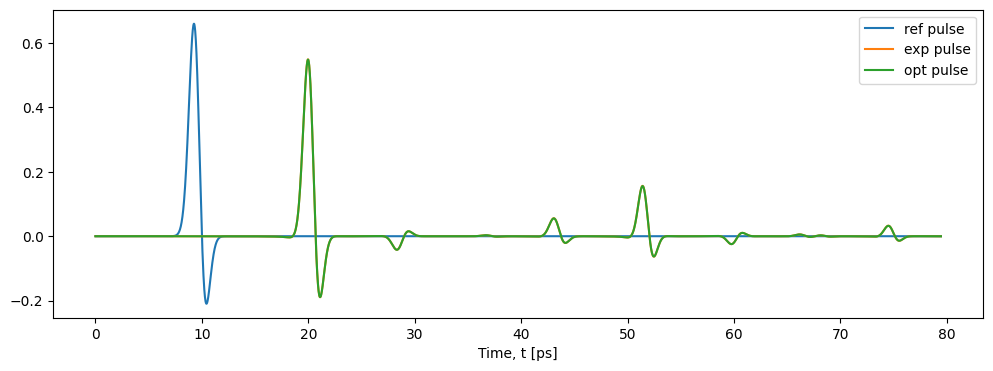

In [4]:
alpha = 1
LE_nk = LayeredExtractor(reference_pulse, experimental_pulse, deltat, bayesian_NK_params, lr=0.001, optimize_mask=optimize_mask)
print(f'Optimizing n and k with initial conditions {layers_nk_init}')
optim_params = LE_nk.optimize(num_iterations=50, updates=5, alpha=alpha)



_, optimal_pulse_nk = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse_nk = optimal_pulse_nk[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optimal_pulse_nk.detach().cpu().numpy(), label='opt pulse')

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

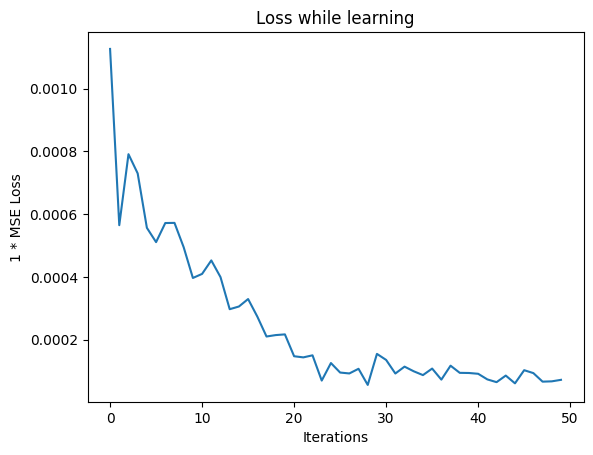

In [5]:
plt.plot(LE_nk.loss_history)
plt.xlabel('Iterations')
plt.ylabel(f'{alpha} * MSE Loss')
plt.title('Loss while learning')

plt.show()

### Plot residuals

In [6]:
n_res = np.zeros(len(optim_params))
k_res = np.zeros(len(optim_params))
i=0
for layer in optim_params:
    n_res[i] = np.real(layer[0]) - np.real(material_params_exp[i][0])
    k_res[i] = np.imag(layer[0]) - np.imag(material_params_exp[i][0])
    print(f'n residual for layer {i}: {n_res[i]}')
    print(f'k residual for layer {i}: {k_res[i]}')
    i+=1

n residual for layer 0: 5.654335021976209e-05
k residual for layer 0: -0.0005181955546140673
n residual for layer 1: 0.0002434253692626953
k residual for layer 1: 0.0006052736565470701


## Extract thicknesses of multiple layers

### Bayesian Optimization to find initial values

In [7]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

optimize_mask = [
    (False, False, True),  
    (False, False, True),    
]

# Initial guess must be within 150um of the correct answer.
layers_D_init = [(n1+1j*k1, 0.9e-3), (n2+1j*k2, 0.4e-3)]
alpha = 10

initial_pulse = simulate_parallel(reference_pulse, layers_D_init, deltat, 0)[1][:L]

BLE_D = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_D_init, optimize_mask=optimize_mask)

print(f'Optimizing n and k with initial conditions {layers_D_init}')
Bayesian_params_D = BLE_D.bayesian_optimization(n_calls=30)

_, Bayesian_pulse_D = simulate_parallel(reference_pulse, Bayesian_params_D, deltat, noise_level=0)
Bayesian_pulse_D = Bayesian_pulse_D[:L]

print(Bayesian_params_D)

Optimizing n and k with initial conditions [((3.46+0.01j), 0.0009), ((2.5+0.015j), 0.0004)]
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - D ∈ (0.00075, 0.00105)
Layer 2 - D ∈ (0.00025, 0.00055)
[((3.46+0.01j), 0.0010022064516056297), ((2.5+0.015j), 0.0004892960410737311)]


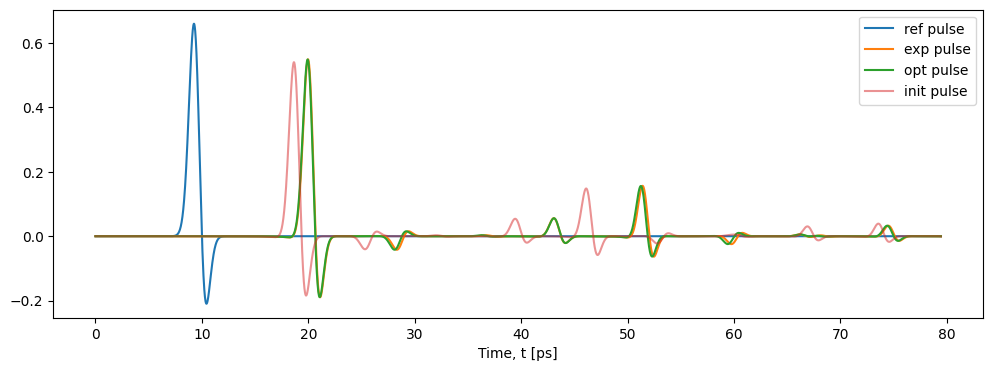

In [8]:
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, Bayesian_pulse_D.detach().cpu().numpy(), label='opt pulse')
plt.plot(t_axis*1e12, initial_pulse.detach().cpu().numpy(), label='init pulse', alpha=0.5)

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Fine-tune on Adam

Optimizing n and k with initial conditions [((3.46+0.01j), 0.0009), ((2.5+0.015j), 0.0004)]
Fine-tuning 2 parameters for 30 iterations.
Iteration 4, Loss: 7.677590e-03, Layer 0: n=3.4600, k=0.01000, D=999.45 µm | Layer 1: n=2.5000, k=0.01500, D=489.36 µm
Iteration 9, Loss: 6.895237e-03, Layer 0: n=3.4600, k=0.01000, D=1007.29 µm | Layer 1: n=2.5000, k=0.01500, D=495.27 µm
Iteration 14, Loss: 4.239914e-03, Layer 0: n=3.4600, k=0.01000, D=1002.32 µm | Layer 1: n=2.5000, k=0.01500, D=495.30 µm
Iteration 19, Loss: 7.462571e-04, Layer 0: n=3.4600, k=0.01000, D=999.75 µm | Layer 1: n=2.5000, k=0.01500, D=496.96 µm
Iteration 24, Loss: 3.679475e-03, Layer 0: n=3.4600, k=0.01000, D=1001.38 µm | Layer 1: n=2.5000, k=0.01500, D=500.47 µm
Iteration 29, Loss: 7.839152e-04, Layer 0: n=3.4600, k=0.01000, D=999.10 µm | Layer 1: n=2.5000, k=0.01500, D=500.57 µm
[((3.4600000381469727+0.009999999776482582j), 0.0009999246103689075), ((2.5+0.014999999664723873j), 0.000500922033097595)]


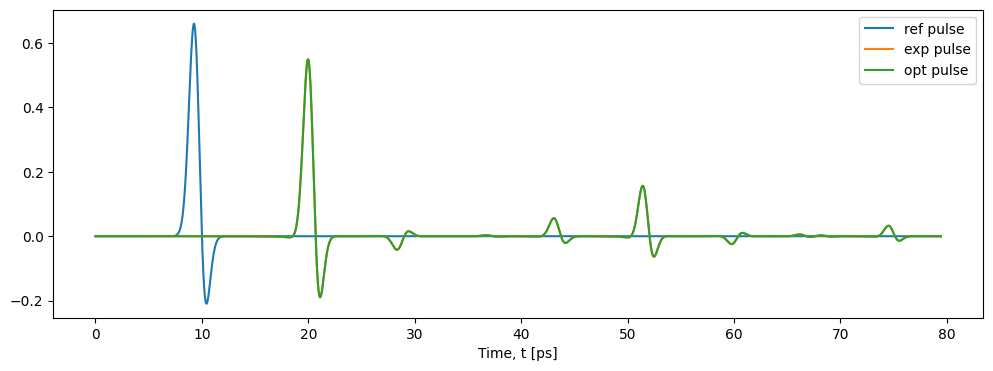

In [9]:
# Initial guess must be within 150um of the correct answer.
Bayesian_init_D = Bayesian_params_D

LE_D = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_init_D, lr=0.01, optimize_mask=optimize_mask)
print(f'Optimizing n and k with initial conditions {layers_D_init}')
optim_params_D = LE_D.optimize(num_iterations=30, updates=5)



_, optim_pulse_D = simulate_parallel(reference_pulse, optim_params_D, deltat, noise_level=0)
optim_pulse_D = optim_pulse_D[:L]

print(optim_params_D)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optim_pulse_D.detach().cpu().numpy(), label='opt pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Calculate residuals

In [10]:
D_res = np.zeros(len(optim_params))
i=0
for layer in optim_params_D:
    D_res[i] = layer[1] - material_params_exp[i][1]
    print(f'Residual for layer {i}: {D_res[i]}')
    i+=1

Residual for layer 0: -7.538963109256919e-08
Residual for layer 1: 9.22033097594966e-07
